<a href="https://colab.research.google.com/github/Medona-Jugi-P/SENTIMENTAL-ANALYSIS-ON-WOMENS-E-COMMERCE-CLOTHING-REVIEW/blob/main/SENTIMENTAL_ANALYSIS_ON_WOMEN'S_E_COMMERCE_CLOTHING_REVIEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import numpy as np
import re
import plotly.express as px
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import GlobalAvgPool1D
import tensorflow as tf

from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
data = pd.read_csv("/content/Womens Clothing E-Commerce Reviews.csv" , index_col=0)
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
data = data.drop(['Title', 'Clothing ID', 'Positive Feedback Count'], axis=1)
data.head()

,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates
1,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses
2,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants
4,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses


In [5]:
# Checking for the missing values
count_NaN = data.isna().sum()
count_NaN

Age                  0
Review Text        845
Rating               0
Recommended IND      0
Division Name       14
Department Name     14
Class Name          14
dtype: int64

In [6]:
# Dropping the missing values in the rows
data = data.dropna(subset=['Review Text', 'Division Name', 'Department Name', 'Class Name'], axis=0)
data = data.reset_index(drop=True)

# Checking for the missing values after the drops
count_NaN_updated = data.isna().sum()
count_NaN_updated

Age                0
Review Text        0
Rating             0
Recommended IND    0
Division Name      0
Department Name    0
Class Name         0
dtype: int64

In [7]:
fig = px.histogram(data['Rating'],
                   labels={'value': 'Rating',
                           'count': 'Frequency',
                           'color': 'Rating'}, color=data['Rating'])
fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Ratings',
                  title_x=0.5, title_font=dict(size=20))
fig.show()

In [8]:
fig = px.histogram(data['Age'], marginal='box',
                   labels={'value': 'Age'})

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Age of the Customers',
                  title_x=0.5, title_font=dict(size=20))
fig.show()

In [9]:
labels = ['Recommended', 'Not Recommended']
values = [data[data['Recommended IND'] == 1]['Recommended IND'].value_counts()[1],
          data[data['Recommended IND'] == 0]['Recommended IND'].value_counts()[0]]
colors = ['green', 'red']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, opacity=0.8)])
fig.update_traces(textinfo='percent+label', marker=dict(line=dict(color='#000000', width=2), colors=colors))
fig.update_layout(title_text='Distribution of the Recommendations', title_x=0.5, title_font=dict(size=20))
fig.show()

In [10]:
fig = px.histogram(data['Age'], color=data['Recommended IND'],
                   labels={'value': 'Age',
                           'color': 'Recommended'}, marginal='box')
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Age and Recommendation',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='overlay')
fig.show()

In [11]:
fig = px.histogram(data['Rating'], color=data['Recommended IND'],
                   labels={'value': 'Rating',
                           'color': 'Recommended?'})
fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Relationship between Ratings and Recommendation',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='group')
fig.show()

**According to this graph above, almost all the Rating 5 and Rating 4 data points are recommended.**

**In addition, Rating 1 and Rating 2 data points have almost no recommendations.**

**For the further steps, I would create a common rating point with the Rating 4 and Rating 5 as well as Rating 1 and Rating 2. In this way, I would shrink the labels therefore, the model would perform better.**

In [12]:
fig = px.histogram(data['Rating'], color=data['Department Name'],
                   labels={'value': 'Rating',
                           'color': 'Department Name'})
fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Relationship between Ratings and Departments',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='group')
fig.show()

In [13]:
fig = px.histogram(data['Department Name'], color=data['Recommended IND'],
                   labels={'value': 'Department Name',
                           'color': 'Recommended?'})
fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Department Name and Recommendation Distribution',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='group')
fig.show()

In [14]:
fig = px.histogram(data['Division Name'], color=data['Recommended IND'],
                   labels={'value': 'Division Name',
                           'color': 'Recommended?'})
fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Division Name and Recommendation Distribution',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='group')
fig.show()

In [15]:
data['length_of_text'] = [len(i.split(' ')) for i in data['Review Text']]
fig = px.histogram(data['length_of_text'], marginal='box',
                   labels={"value": "Length of the Text",
                           "color": 'Recommended'},
                   color=data['Recommended IND'])

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Length of the Texts',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='overlay')
fig.show()

**As you can see from the figure above, Recommended and not Recommended products almost have the same distribution length of text.**

In [16]:
FreqOfWords = data['Review Text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (Before Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

**According to this Treemap above, the top frequent 200 words usually include a stopword. For the further step of this notebook, I will remove them from the text.**

Data Preprocessing

In [17]:
# Lower Character all the Texts
data['Review Text'] = data['Review Text'].str.lower()
data['Review Text'].head()

0    absolutely wonderful - silky and sexy and comf...
1    love this dress!  it's sooo pretty.  i happene...
2    i had such high hopes for this dress and reall...
3    i love, love, love this jumpsuit. it's fun, fl...
4    this shirt is very flattering to all due to th...
Name: Review Text, dtype: object

In [18]:
# Removing Punctuations and Numbers from the Text
def remove_punctuations_numbers(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)


data['Review Text'] = data['Review Text'].apply(remove_punctuations_numbers)

In [19]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [20]:
def tokenization(inputs):  # Ref.1
    return word_tokenize(inputs)


data['text_tokenized'] = data['Review Text'].apply(tokenization)
data['text_tokenized'].head()

0    [absolutely, wonderful, silky, and, sexy, and,...
1    [love, this, dress, it, s, sooo, pretty, i, ha...
2    [i, had, such, high, hopes, for, this, dress, ...
3    [i, love, love, love, this, jumpsuit, it, s, f...
4    [this, shirt, is, very, flattering, to, all, d...
Name: text_tokenized, dtype: object

In [21]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')


def stopwords_remove(inputs):  # Ref.2
    return [k for k in inputs if k not in stop_words]


data['text_stop'] = data['text_tokenized'].apply(stopwords_remove)
data['text_stop'].head()

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happened, find, st...
2    [high, hopes, dress, really, wanted, work, ini...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flattering, due, adjustable, front, ti...
Name: text_stop, dtype: object

In [22]:
lemmatizer = WordNetLemmatizer()


def lemmatization(inputs):  # Ref.1
    return [lemmatizer.lemmatize(word=kk, pos='v') for kk in inputs]


data['text_lemmatized'] = data['text_stop'].apply(lemmatization)
data['text_lemmatized'].head()

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happen, find, stor...
2    [high, hop, dress, really, want, work, initial...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flatter, due, adjustable, front, tie, ...
Name: text_lemmatized, dtype: object

In [23]:
# Removing Words less than length 2
def remove_less_than_2(inputs):  # Ref.1
    return [j for j in inputs if len(j) > 2]


data['final'] = data['text_lemmatized'].apply(remove_less_than_2)

In [24]:
# Joining Tokens into Sentences
data['final'] = data['final'].str.join(' ')
data['final'].head()

0          absolutely wonderful silky sexy comfortable
1    love dress sooo pretty happen find store glad ...
2    high hop dress really want work initially orde...
3    love love love jumpsuit fun flirty fabulous ev...
4    shirt flatter due adjustable front tie perfect...
Name: final, dtype: object

After Cleaning

In [25]:
FreqOfWords = data['final'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (After Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

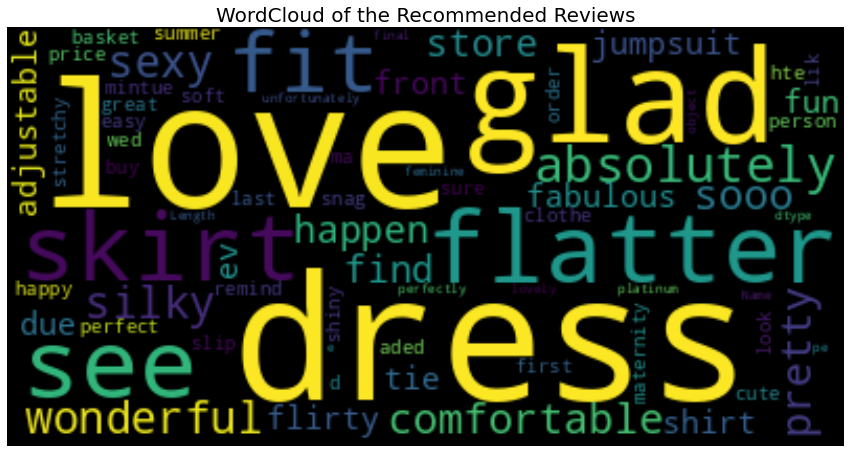

In [26]:
data_recommended = data[data['Recommended IND'] == 1]  # Dataframe that only includes recommended reviews
data_not_recommended = data[data['Recommended IND'] == 0]  # # Dataframe that only includes not recommended reviews

WordCloud_recommended = WordCloud(max_words=500,
                                  random_state=30,
                                  collocations=True).generate(str((data_recommended['final'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_recommended, interpolation='bilinear')
plt.title('WordCloud of the Recommended Reviews', fontsize=20)
plt.axis("off")
plt.show()

In [27]:
FreqOfWords = data_recommended['final'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)
fig.update_layout(title_text='Top Frequent 200 Words in the Recommended Reviews',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

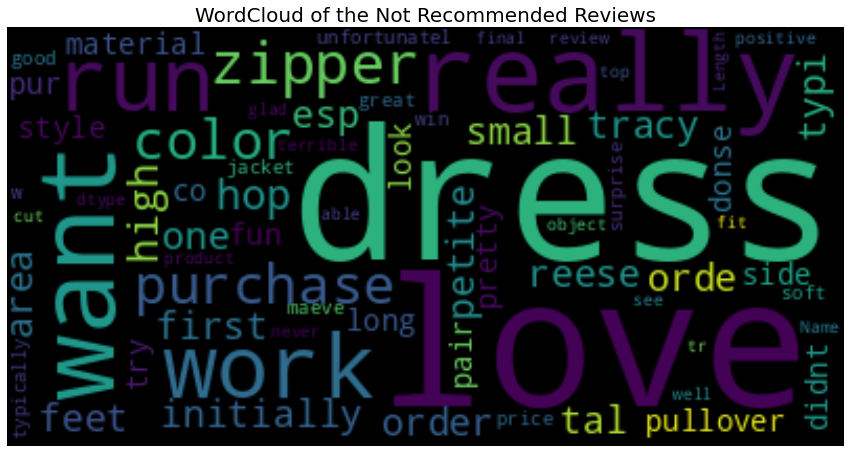

In [28]:
WordCloud_not_recommended = WordCloud(max_words=500,
                                      random_state=30,
                                      collocations=True).generate(str((data_not_recommended['final'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_not_recommended, interpolation='bilinear')
plt.title('WordCloud of the Not Recommended Reviews', fontsize=20)
plt.axis("off")
plt.show()

In [29]:
FreqOfWords = data_not_recommended['final'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)
fig.update_layout(title_text='Top Frequent 200 Words in the Not Recommended Reviews',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

In [30]:
data['length_of_text'] = [len(i.split(' ')) for i in data['final']]
fig = px.histogram(data['length_of_text'], marginal='box',
                   labels={"value": "Length of the Text",
                           "color": 'Recommended?'},
                   color=data['Recommended IND'])

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Length of the Texts after Cleaning',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='overlay')
fig.show()

Train test Splt

In [31]:
# I will only use Text data to predict Recommendation
y = data['Recommended IND']
X = data['final']

X.head()

0          absolutely wonderful silky sexy comfortable
1    love dress sooo pretty happen find store glad ...
2    high hop dress really want work initially orde...
3    love love love jumpsuit fun flirty fabulous ev...
4    shirt flatter due adjustable front tie perfect...
Name: final, dtype: object

In [32]:
# Train-Test-Validation Split
x, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=13)  # Test: %20

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=13)  # Val: %20

print('Shape of the X_train:', X_train.shape)
print('Shape of the X_test:', X_test.shape)
print('Shape of the X_val:', X_val.shape)
print('--'*20)
print('Shape of the y_train:', y_train.shape)
print('Shape of the y_test:', y_test.shape)
print('Shape of the y_val:', y_val.shape)

Shape of the X_train: (13576,)
Shape of the X_test: (4526,)
Shape of the X_val: (4526,)
----------------------------------------
Shape of the y_train: (13576,)
Shape of the y_test: (4526,)
Shape of the y_val: (4526,)


In [33]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

Tokenized_train = tokenizer.texts_to_sequences(X_train)
Tokenized_val = tokenizer.texts_to_sequences(X_val)

print('Non-tokenized Version: ', X_train[0])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[0]]))
print('--'*20)
print('Non-tokenized Version: ', X_train[80])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[80]]))

Non-tokenized Version:  absolutely wonderful silky sexy comfortable
Tokenized Version:  [[161, 366, 748, 445, 33]]
----------------------------------------
Non-tokenized Version:  usually petite since dress not come petites try fit lbs dress hit knee hem bite not overwhelm dress look stun great vibrant color dark hair make classic elegant dress look contemporary stylish try store salesperson others happen see rave tell grab glad plan wear spring daughte
Tokenized Version:  [[61, 47, 150, 2, 7, 109, 769, 23, 3, 68, 2, 146, 269, 223, 38, 7, 746, 2, 8, 397, 12, 356, 11, 278, 1025, 18, 342, 459, 2, 8, 2151, 344, 23, 57, 1885, 350, 601, 62, 1723, 432, 631, 218, 313, 6, 212, 6315]]


In [34]:
maxlen = 50
Padded_train = pad_sequences(Tokenized_train, maxlen=maxlen, padding='pre')
Padded_val = pad_sequences(Tokenized_val, maxlen=maxlen, padding='pre')

LSTM Model

In [35]:
# Creating the Model
model = Sequential()

model.add(Embedding(num_words, 16, input_length=maxlen))
model.add(Dropout(0.2))

model.add(GlobalAvgPool1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

opt = tf.optimizers.Adam(learning_rate = 0.55e-3)  # Learning Rate

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
__________________________________________________

In [36]:
# Training the Model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', patience=5,
                                                  restore_best_weights=True)

epochs = 100
hist = model.fit(Padded_train, y_train, epochs=epochs,
                 validation_data=(Padded_val, y_val),
                 callbacks=[early_stopping], batch_size=32)

Epoch 1/100
425/425 [==============================] - 31s 58ms/step - loss: 0.5729 - accuracy: 0.8013 - val_loss: 0.4711 - val_accuracy: 0.8239
Epoch 2/100
425/425 [==============================] - 6s 15ms/step - loss: 0.4660 - accuracy: 0.8201 - val_loss: 0.4420 - val_accuracy: 0.8239
Epoch 3/100
425/425 [==============================] - 5s 12ms/step - loss: 0.4494 - accuracy: 0.8201 - val_loss: 0.4267 - val_accuracy: 0.8239
Epoch 4/100
425/425 [==============================] - 2s 5ms/step - loss: 0.4319 - accuracy: 0.8201 - val_loss: 0.4108 - val_accuracy: 0.8239
Epoch 5/100
425/425 [==============================] - 2s 5ms/step - loss: 0.4146 - accuracy: 0.8201 - val_loss: 0.3935 - val_accuracy: 0.8239
Epoch 6/100
425/425 [==============================] - 3s 8ms/step - loss: 0.3960 - accuracy: 0.8202 - val_loss: 0.3745 - val_accuracy: 0.8248
Epoch 7/100
425/425 [==============================] - 4s 8ms/step - loss: 0.3762 - accuracy: 0.8233 - val_loss: 0.3553 - val_accuracy: 0.

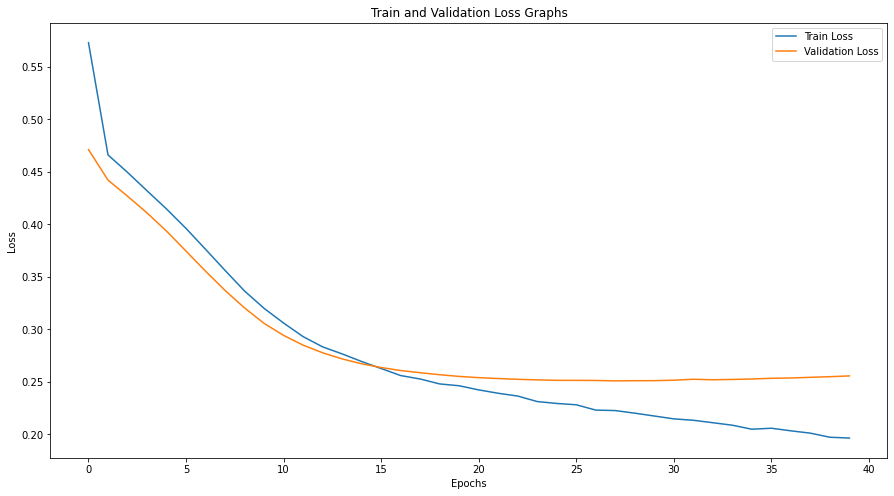

In [37]:
plt.figure(figsize=(15, 8))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

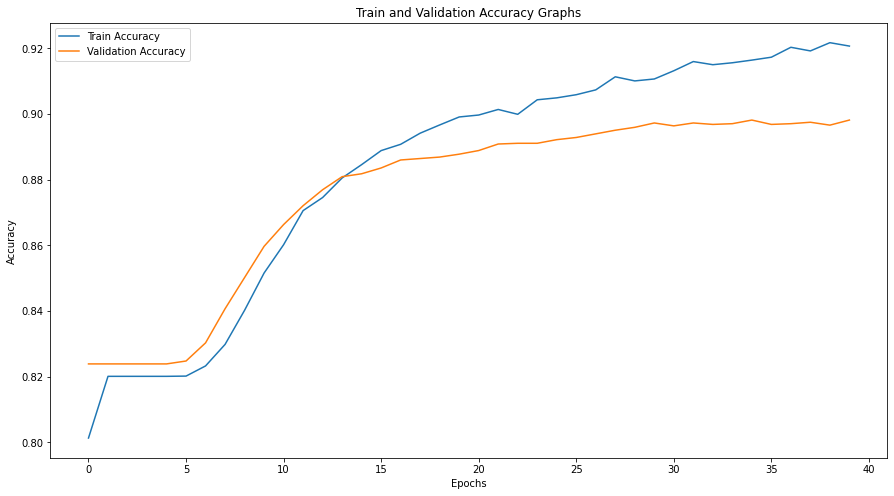

In [38]:
plt.figure(figsize=(15, 8))
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy Graphs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [39]:
X_test = X_test.apply(tokenization)
X_test = X_test.apply(stopwords_remove)
X_test = X_test.apply(lemmatization)
X_test = X_test.str.join(' ')

X_test.head()

10818                              low waisted weird liner
779      shirt not good look gal hips fit top tight ord...
10907    love dress long enough dramatic graze feet wit...
17442    understand pencil skirt gon body hug however r...
832      order shirt wear pair pant return one reason t...
Name: final, dtype: object

In [40]:
Tokenized_test = tokenizer.texts_to_sequences(X_test)
Padded_test = pad_sequences(Tokenized_test, maxlen=maxlen, padding='pre')

test_evaluate = model.evaluate(Padded_test, y_test)

142/142 [==============================] - 0s 3ms/step - loss: 0.2692 - accuracy: 0.8880


In [41]:
pred_train_lstm = model.predict(Padded_train)
pred_test_lstm = model.predict(Padded_test)

142/142 [==============================] - 0s 2ms/step


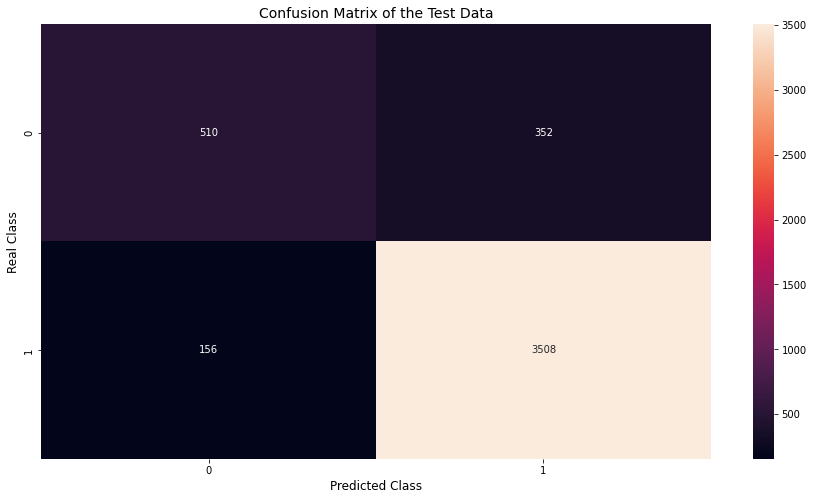

In [42]:
for i, x in enumerate(pred_test_lstm):
    if 0 <= x < 0.49:
        pred_test_lstm[i] = 0
    else:
        pred_test_lstm[i] = 1

for i, x in enumerate(pred_train_lstm):
    if 0 <= x < 0.49:
        pred_train_lstm[i] = 0
    else:
        pred_train_lstm[i] = 1

conf_mat = confusion_matrix(y_true=y_test, y_pred=pred_test_lstm)
plt.figure(figsize=(15, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix of the Test Data', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

In [43]:
# Accuracy
train_acc_lstm = round(accuracy_score(y_train, pred_train_lstm) * 100, 2)
print('Train Accuracy of the LSTM: %', train_acc_lstm)
test_acc_lstm = round(accuracy_score(y_test, pred_test_lstm) * 100, 2)
print('Test Accuracy of the LSTM: %', test_acc_lstm)
print('--' * 20)

# Precision
train_precision_lstm = round(precision_score(y_train, pred_train_lstm) * 100, 2)
print('Train Precision of the LSTM: %', train_precision_lstm)
precision_lstm = round(precision_score(y_test, pred_test_lstm) * 100, 2)
print('Test Precision of the LSTM: %', precision_lstm)
print('--' * 20)

# Recall
train_recall_lstm = round(recall_score(y_train, pred_train_lstm) * 100, 2)
print('Train Recall of the LSTM: %', train_recall_lstm)
recall_lstm = round(recall_score(y_test, pred_test_lstm) * 100, 2)
print('Test Recall of the LSTM: %', recall_lstm)

Train Accuracy of the LSTM: % 92.1
Test Accuracy of the LSTM: % 88.78
----------------------------------------
Train Precision of the LSTM: % 93.61
Test Precision of the LSTM: % 90.88
----------------------------------------
Train Recall of the LSTM: % 96.98
Test Recall of the LSTM: % 95.74


Testing the LSTM model

In [44]:
def predict_recommendation(input_text):  # The function for doing all the previous steps
    input_text = input_text.lower()
    input_text = re.sub(r'[^a-zA-Z]', ' ', input_text)
    input_text = tokenization(input_text)
    input_text = stopwords_remove(input_text)
    input_text = lemmatization(input_text)
    input_text = ' '.join(input_text)
    input_text = tokenizer.texts_to_sequences([input_text])
    input_text = pad_sequences(input_text, maxlen=maxlen, padding='pre')
    input_text = model.predict(input_text)
    if input_text >= 0.5:
        input_text = f'Recommended with %{round(float(input_text*100), 2)}'
    else:
        input_text = f'Not Recommended with %{round(float(input_text*100), 2)}'

    return print(input_text)

In [45]:
# This reviews above are taken from several websites for testing the model with real world data. You can find these websites in the Ref.5
predict_recommendation("The clothes are such poor quality and look nothing like they do on the website. I order 2 packages of fast fashion a year just as a treat, and I sorely regret buying from here. Fabrics are cheaper than what they charge, their seems to be no thought of sizing consitency and so on")

1/1 [==============================] - 0s 21ms/step
Not Recommended with %19.1


In [46]:
predict_recommendation("Beautiful colour of lemon great fit and length here in three days all l need is some fine weather to show if at it's best!!!!!")

1/1 [==============================] - 0s 19ms/step
Recommended with %95.15
